# BTC-USD Monte Carlo Simulation for 2018

In [1]:
import quandl
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 20
np.random.seed = 42

In [3]:
btc = quandl.get('BCHARTS/BITSTAMPUSD')
btc = btc['2015-01-01':]

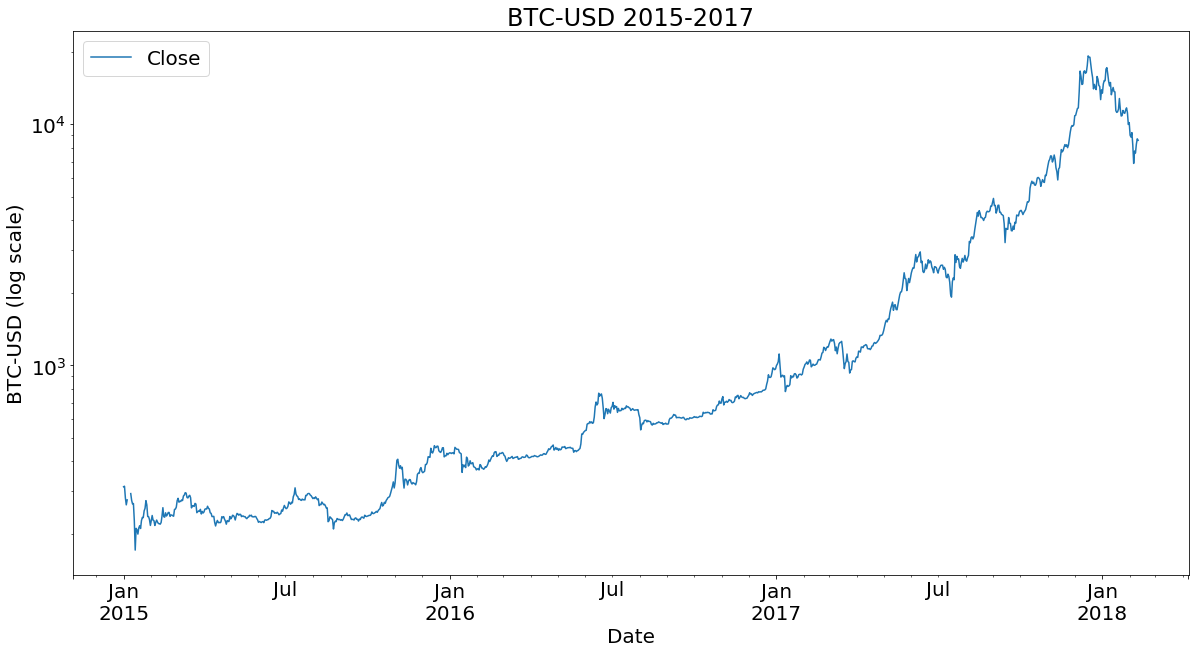

In [4]:
btc.replace(0, np.nan, inplace=True)

btc[[
    'Close',
]].plot(
    figsize=(20, 10),
    logy=True
)

plt.title('BTC-USD 2015-2017')
plt.ylabel('BTC-USD (log scale)')
plt.legend();

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Daily Return,Log Daily Return
Date,,,,,,,,,
2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05,315.637119,0.000000,0.000000
2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06,314.981849,0.005130,0.005117
2015-01-03,315.42,316.58,280.00,282.00,21752.719146,6.475952e+06,297.707695,-0.105954,-0.111998
2015-01-04,280.00,289.39,255.00,264.00,41441.278553,1.126676e+07,271.872950,-0.063830,-0.065958
2015-01-05,264.55,280.00,264.07,276.80,9528.271002,2.596898e+06,272.546601,0.048485,0.047346


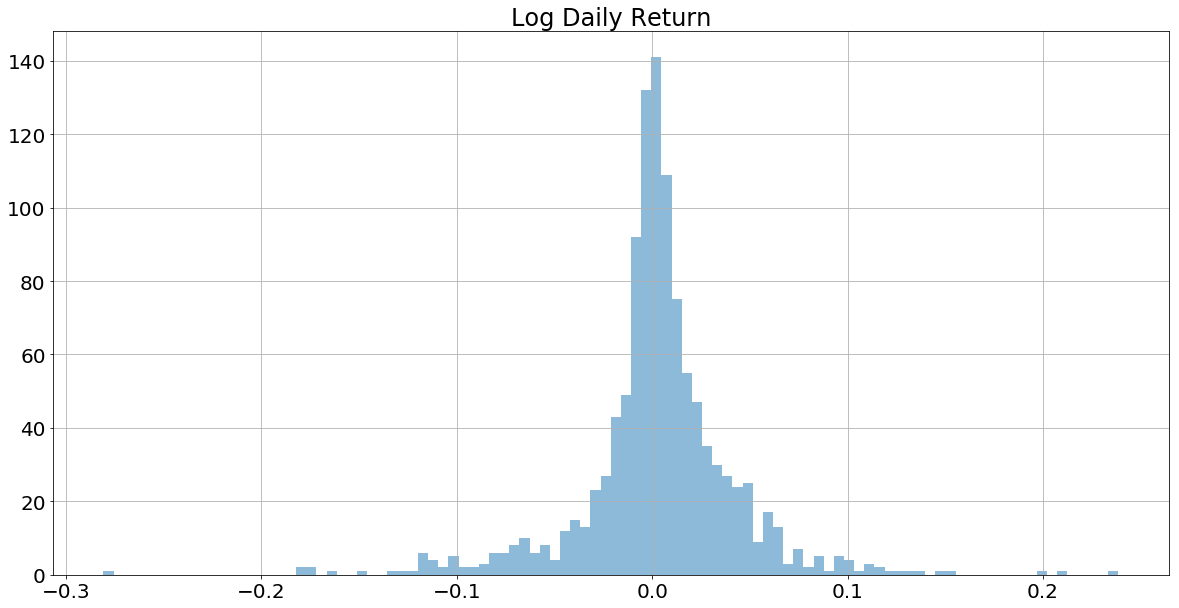

In [5]:
btc['Daily Return'] = (btc['Close'].pct_change()).fillna(0)
btc['Log Daily Return'] = btc['Daily Return'].apply(lambda x: np.log(1 + x))

display(btc.head())

btc[['Log Daily Return']].hist(
    bins=100,
    figsize=(20, 10),
    alpha=0.5
);

In [6]:
std = btc['Log Daily Return'].std()
drift = btc['Log Daily Return'].mean() - 0.5 * btc['Log Daily Return'].var()

$$ \text{daily_returns} = e^{r} $$

$$ r = drift + stdev * z $$

In [7]:
future_index = pd.date_range(start=dt.date.today(), end='2019-01-01')
t_intervals = len(future_index)
iterations = 100000

simulated_daily_returns = np.exp(
    drift + std * stats.norm.ppf(
        np.random.rand(t_intervals, iterations)
    )
)

In [8]:
S = np.zeros_like(simulated_daily_returns)
S[0] = btc['Close'][-1]

for t in range(1, len(S)):
    S[t] = S[t - 1] * simulated_daily_returns[t]

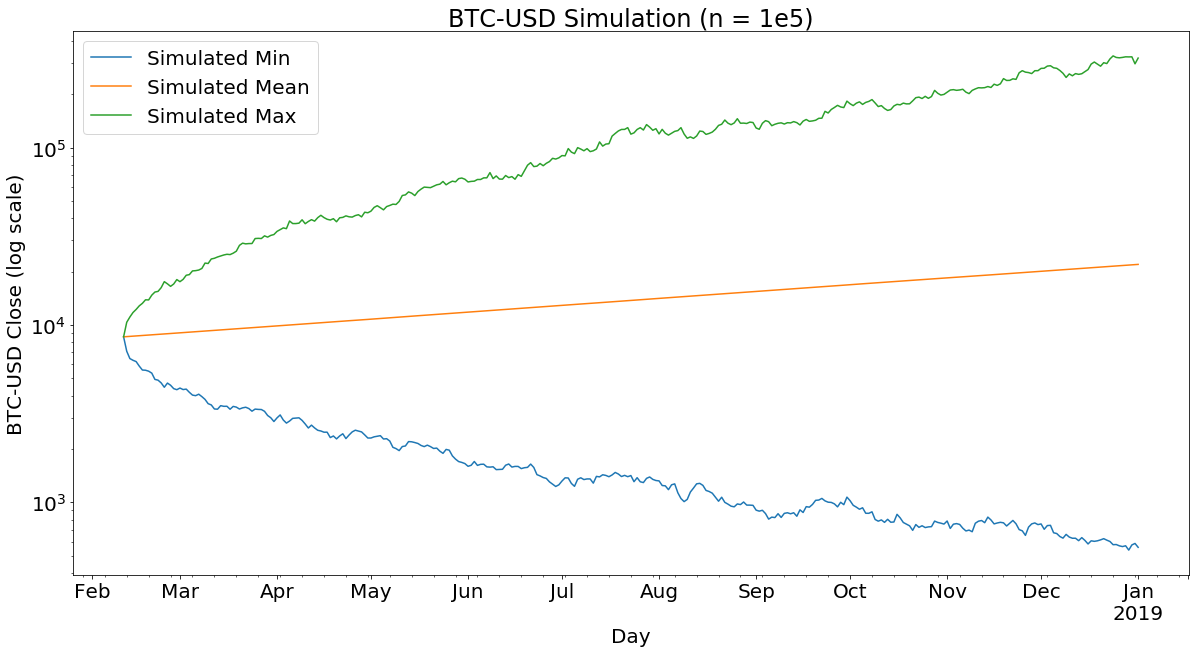

In [9]:
pd.DataFrame(
    np.array([
        np.min(S, axis=1),
        np.mean(S, axis=1),
        np.max(S, axis=1),
    ]).T,
    columns=['Simulated Min', 'Simulated Mean', 'Simulated Max'],
    index=future_index
).plot(
    figsize=(20, 10),
    logy=True
)

plt.title('BTC-USD Simulation (n = 1e5)')
plt.ylabel('BTC-USD Close (log scale)')
plt.xlabel('Day')
plt.legend();

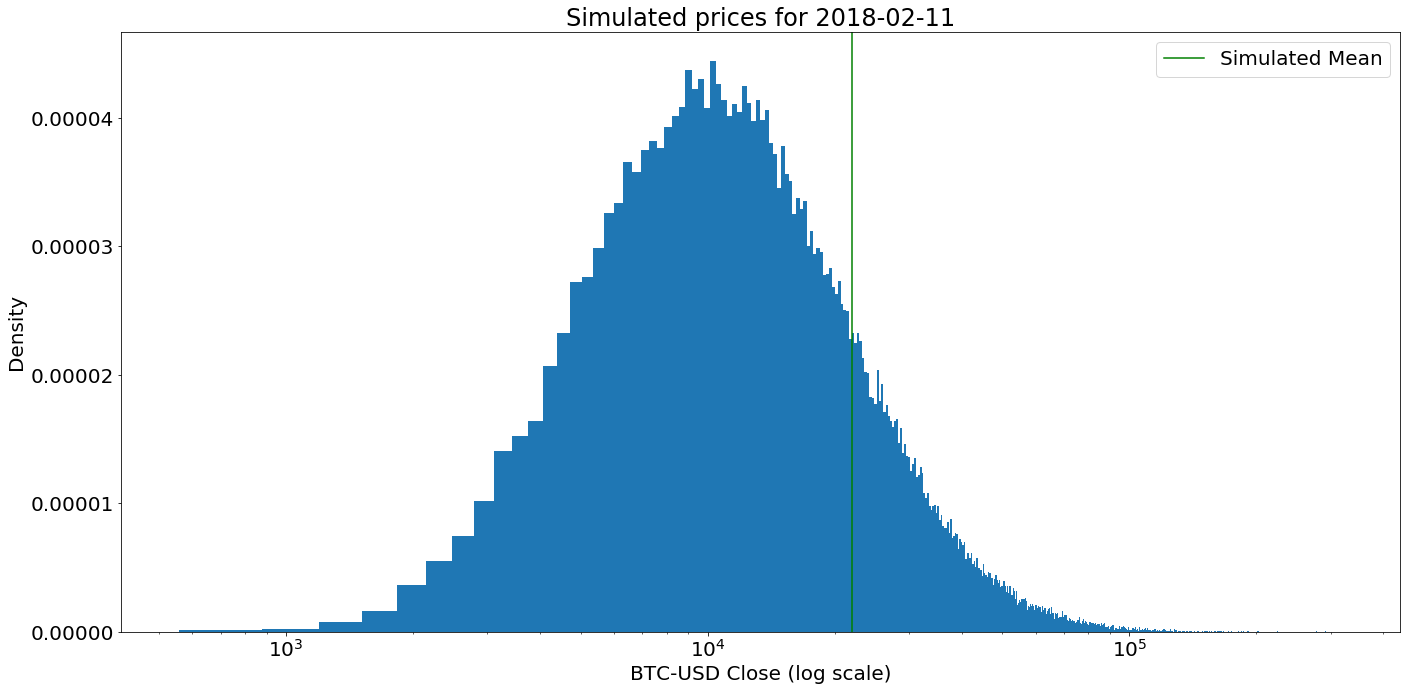

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(S[-1], bins=1000, density=True)
plt.axvline(S[-1].mean(), c='green', label='Simulated Mean')
plt.xscale('log')
plt.title('Simulated prices for 2018-02-11')
plt.ylabel('Density')
plt.xlabel('BTC-USD Close (log scale)')
plt.legend()
plt.tight_layout()
plt.show();